## Toxic Comment Classification THE ANALYSIS

## PART III

In [2]:
%%time
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

import tokenizers
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import warnings
warnings.simplefilter('ignore')

train = pd.read_csv('../Toxic-Comment-Classification/input/sample_submission.csv', nrows = 2000)
test = pd.read_csv('../Toxic-Comment-Classification/input/test.csv', nrows = 400)
submission = pd.read_csv('../Toxic-Comment-Classification/input/test_labels.csv')

SEED = 34
def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
random_seed(SEED)

def clean_text(text):

    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


train['clean_text'] = train['comment_text'].apply(str).apply(lambda x: clean_text(x))
test['clean_text'] = test['comment_text'].apply(str).apply(lambda x: clean_text(x))

kfold = 5
train['kfold'] = train.index % kfold

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
max_len = 256

class BertDataSet(Dataset):
    
    def __init__(self, sentences, toxic_labels):
        self.sentences = sentences
        #target is a matrix with shape [#1 x #6(toxic, obscene, etc)]
        self.targets = toxic_labels.to_numpy()
    
    def __len__(self):
        return len(self.sentences)
    
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        bert_senten = tokenizer.encode_plus(sentence, 
                                            add_special_tokens = True, # [CLS],[SEP]
                                            max_length = max_len,
                                            pad_to_max_length = True,
                                            truncation = True,
                                            return_attention_mask = True
                                             )
        ids = torch.tensor(bert_senten['input_ids'], dtype = torch.long)
        mask = torch.tensor(bert_senten['attention_mask'], dtype = torch.long)
        toxic_label = torch.tensor(self.targets[idx], dtype = torch.float)
        
        
        return {
            'ids' : ids,
            'mask' : mask,
            'toxic_label':toxic_label
        }

epochs = 5
train_batch = 32
valid_batch = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_fn = nn.BCEWithLogitsLoss()
loss_fn.to(device)
scaler = torch.cuda.amp.GradScaler()

def training(train_dataloader, model, optimizer, scheduler):
    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    
    for a in train_dataloader:
        losses = []
        optimizer.zero_grad()
        
        #allpreds = []
        #alltargets = []
        
        with torch.cuda.amp.autocast():
            
            ids = a['ids'].to(device, non_blocking = True)
            mask = a['mask'].to(device, non_blocking = True) 

            output = model(ids, mask) #This gives model as output, however we want the values at the output
            output = output['logits'].squeeze(-1).to(torch.float32)

            output_probs = torch.sigmoid(output)
            preds = torch.where(output_probs > 0.5, 1, 0)
            
            toxic_label = a['toxic_label'].to(device, non_blocking = True) 
            loss = loss_fn(output, toxic_label)            
            
            losses.append(loss.item())
            #allpreds.append(output.detach().cpu().numpy())
            #alltargets.append(toxic.detach().squeeze(-1).cpu().numpy())
            correct_predictions += torch.sum(preds == toxic_label)
        
        scaler.scale(loss).backward() #Multiplies (‘scales’) a tensor or list of tensors by the scale factor.
                                      #Returns scaled outputs. If this instance of GradScaler is not enabled, outputs are returned unmodified.
        scaler.step(optimizer) #Returns the return value of optimizer.step(*args, **kwargs).
        scaler.update() #Updates the scale factor.If any optimizer steps were skipped the scale is multiplied by backoff_factor to reduce it. 
                        #If growth_interval unskipped iterations occurred consecutively, the scale is multiplied by growth_factor to increase it
        scheduler.step() # Update learning rate schedule
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_train)*6)
    
    return losses, accuracy

def validating(valid_dataloader, model):
    
    model.eval()
    correct_predictions = 0
    all_output_probs = []
    
    for a in valid_dataloader:
        losses = []
        ids = a['ids'].to(device, non_blocking = True)
        mask = a['mask'].to(device, non_blocking = True)
        output = model(ids, mask)
        output = output['logits'].squeeze(-1).to(torch.float32)
        output_probs = torch.sigmoid(output)
        preds = torch.where(output_probs > 0.5, 1, 0)
            
        toxic_label = a['toxic_label'].to(device, non_blocking = True)
        loss = loss_fn(output, toxic_label)
        losses.append(loss.item())
        all_output_probs.extend(output_probs.detach().cpu().numpy())
        
        correct_predictions += torch.sum(preds == toxic_label)
        corr_preds = correct_predictions.detach().cpu().numpy()
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_valid)*6)
    
    return losses, accuracy, all_output_probs

KeyError: 'comment_text'

  0%|          | 0/5 [00:00<?, ?it/s]Some weights of the model checkpoint at ../input/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were 

-------------- Fold = 0-------------
-------------- Epoch = 0-------------
train losses: 0.2320 train accuracy: 0.743
valid losses: 0.1977 valid accuracy: 0.964
Found an improved model! :)



 20%|██        | 1/5 [00:39<02:39, 39.97s/it]

-------------- Epoch = 1-------------
train losses: 0.1631 train accuracy: 0.966
valid losses: 0.1033 valid accuracy: 0.975
Found an improved model! :)



 40%|████      | 2/5 [01:19<01:59, 39.96s/it]

-------------- Epoch = 2-------------
train losses: 0.0446 train accuracy: 0.976
valid losses: 0.0994 valid accuracy: 0.978
Found an improved model! :)



 60%|██████    | 3/5 [01:59<01:19, 39.99s/it]

-------------- Epoch = 3-------------



 80%|████████  | 4/5 [02:35<00:38, 38.39s/it]

train losses: 0.1626 train accuracy: 0.979
valid losses: 0.1059 valid accuracy: 0.978
-------------- Epoch = 4-------------



 20%|██        | 1/5 [03:22<13:31, 202.95s/it]

train losses: 0.0464 train accuracy: 0.980
valid losses: 0.1031 valid accuracy: 0.978


Some weights of the model checkpoint at ../input/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkp

-------------- Fold = 1-------------
-------------- Epoch = 0-------------
train losses: 0.1976 train accuracy: 0.755
valid losses: 0.2751 valid accuracy: 0.955
Found an improved model! :)



 20%|██        | 1/5 [00:38<02:35, 38.89s/it]

-------------- Epoch = 1-------------
train losses: 0.1227 train accuracy: 0.964
valid losses: 0.2442 valid accuracy: 0.955
Found an improved model! :)



 40%|████      | 2/5 [01:19<01:59, 39.76s/it]

-------------- Epoch = 2-------------
train losses: 0.0628 train accuracy: 0.963
valid losses: 0.1958 valid accuracy: 0.955
Found an improved model! :)



 60%|██████    | 3/5 [01:58<01:19, 39.65s/it]

-------------- Epoch = 3-------------
train losses: 0.1446 train accuracy: 0.964
valid losses: 0.1673 valid accuracy: 0.955
Found an improved model! :)



 80%|████████  | 4/5 [02:38<00:39, 39.74s/it]

-------------- Epoch = 4-------------



 40%|████      | 2/5 [06:39<09:57, 199.12s/it]

train losses: 0.1334 train accuracy: 0.966
valid losses: 0.1801 valid accuracy: 0.958


Some weights of the model checkpoint at ../input/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkp

-------------- Fold = 2-------------
-------------- Epoch = 0-------------
train losses: 0.2794 train accuracy: 0.730
valid losses: 0.1263 valid accuracy: 0.956
Found an improved model! :)



 20%|██        | 1/5 [00:38<02:34, 38.59s/it]

-------------- Epoch = 1-------------
train losses: 0.1479 train accuracy: 0.967
valid losses: 0.0622 valid accuracy: 0.967
Found an improved model! :)



 40%|████      | 2/5 [01:19<01:59, 39.70s/it]

-------------- Epoch = 2-------------
train losses: 0.1100 train accuracy: 0.974
valid losses: 0.0403 valid accuracy: 0.969
Found an improved model! :)



 60%|██████    | 3/5 [01:58<01:18, 39.49s/it]

-------------- Epoch = 3-------------
train losses: 0.0799 train accuracy: 0.978
valid losses: 0.0328 valid accuracy: 0.971
Found an improved model! :)



 80%|████████  | 4/5 [02:37<00:39, 39.54s/it]

-------------- Epoch = 4-------------
train losses: 0.0641 train accuracy: 0.981
valid losses: 0.0311 valid accuracy: 0.970
Found an improved model! :)



 60%|██████    | 3/5 [10:02<06:42, 201.13s/it]Some weights of the model checkpoint at ../input/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica

-------------- Fold = 3-------------
-------------- Epoch = 0-------------
train losses: 0.1853 train accuracy: 0.838
valid losses: 0.1761 valid accuracy: 0.968
Found an improved model! :)



 20%|██        | 1/5 [00:38<02:35, 38.84s/it]

-------------- Epoch = 1-------------
train losses: 0.1058 train accuracy: 0.961
valid losses: 0.1157 valid accuracy: 0.968
Found an improved model! :)



 40%|████      | 2/5 [01:18<01:58, 39.39s/it]

-------------- Epoch = 2-------------
train losses: 0.0716 train accuracy: 0.962
valid losses: 0.0974 valid accuracy: 0.968
Found an improved model! :)



 60%|██████    | 3/5 [01:57<01:18, 39.38s/it]

-------------- Epoch = 3-------------
train losses: 0.0653 train accuracy: 0.963
valid losses: 0.0918 valid accuracy: 0.969
Found an improved model! :)



 80%|████████  | 4/5 [02:37<00:39, 39.34s/it]

-------------- Epoch = 4-------------
train losses: 0.0637 train accuracy: 0.963
valid losses: 0.0918 valid accuracy: 0.969
Found an improved model! :)



 80%|████████  | 4/5 [13:21<03:20, 200.09s/it]Some weights of the model checkpoint at ../input/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica

-------------- Fold = 4-------------
-------------- Epoch = 0-------------
train losses: 0.1759 train accuracy: 0.785
valid losses: 0.1299 valid accuracy: 0.967
Found an improved model! :)



 20%|██        | 1/5 [00:38<02:35, 38.83s/it]

-------------- Epoch = 1-------------
train losses: 0.1270 train accuracy: 0.961
valid losses: 0.0554 valid accuracy: 0.967
Found an improved model! :)



 40%|████      | 2/5 [01:19<01:59, 39.82s/it]

-------------- Epoch = 2-------------
train losses: 0.0643 train accuracy: 0.969
valid losses: 0.0531 valid accuracy: 0.971
Found an improved model! :)



 60%|██████    | 3/5 [01:58<01:19, 39.74s/it]

-------------- Epoch = 3-------------
train losses: 0.0399 train accuracy: 0.979
valid losses: 0.0346 valid accuracy: 0.974
Found an improved model! :)



 80%|████████  | 4/5 [02:38<00:39, 39.57s/it]

-------------- Epoch = 4-------------
train losses: 0.0640 train accuracy: 0.981
valid losses: 0.0339 valid accuracy: 0.975
Found an improved model! :)



100%|██████████| 5/5 [16:40<00:00, 200.13s/it]


CPU times: user 15min 3s, sys: 44.7 s, total: 15min 47s
Wall time: 16min 40s


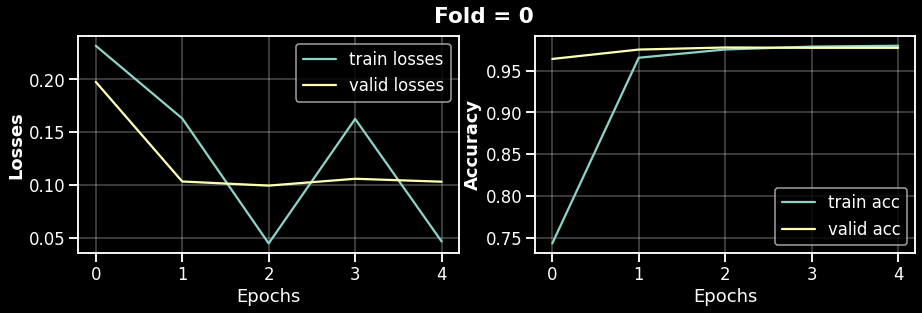

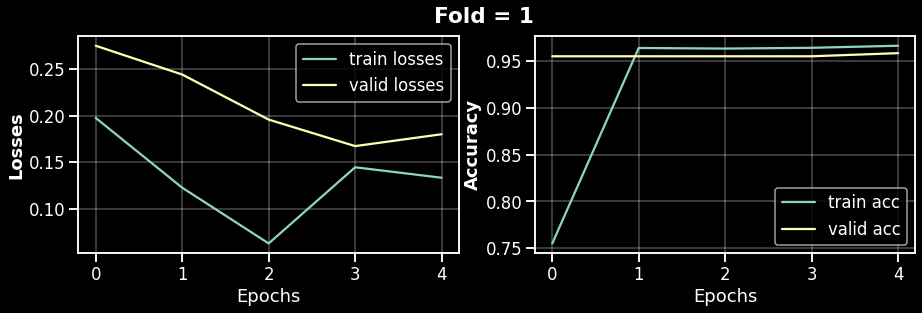

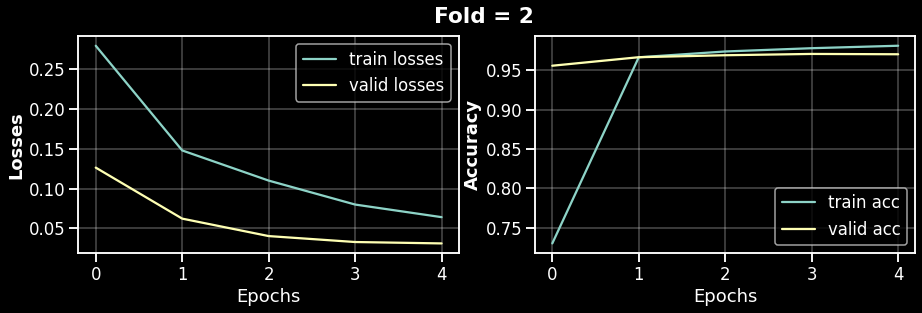

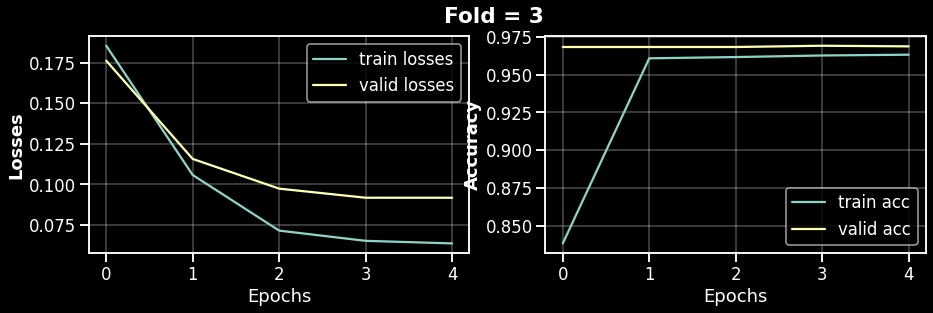

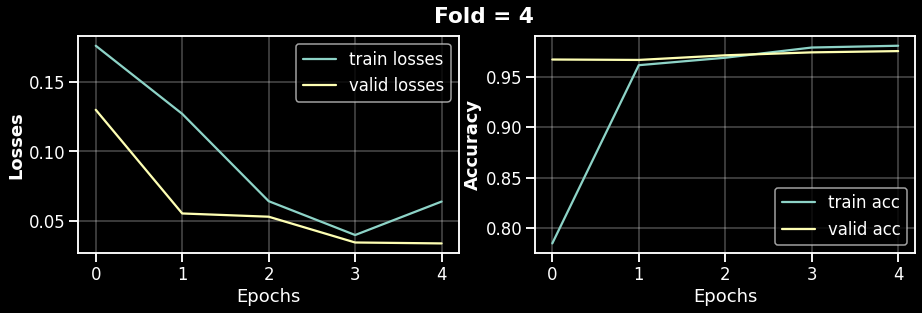

In [2]:
%%time

best_scores = []
for fold in tqdm(range(0,5)):

    # initializing the data
    p_train = train[train['kfold'] != fold].reset_index(drop = True)
    p_valid = train[train['kfold'] == fold].reset_index(drop = True)

    train_dataset = BertDataSet(p_train['clean_text'], p_train[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])
    valid_dataset = BertDataSet(p_valid['clean_text'], p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])

    train_dataloader = DataLoader(train_dataset, batch_size = train_batch, shuffle = True, num_workers = 4, pin_memory = True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = valid_batch, shuffle = False, num_workers = 4, pin_memory = True)

    model = transformers.BertForSequenceClassification.from_pretrained("../Toxic-Comment-Classification/bert-base-cased", num_labels = 6)
    model.to(device)
    
    LR = 2e-5
    optimizer = AdamW(model.parameters(), LR,betas = (0.9, 0.999), weight_decay = 1e-2) # AdamW optimizer

    train_steps = int(len(p_train)/train_batch * epochs)
    num_steps = int(train_steps * 0.1)

    scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)
    
    best_score = 1000
    train_accs = []
    valid_accs = []
    train_losses = []
    valid_losses = []
    best_valid_probs = []
    
    print("-------------- Fold = " + str(fold) + "-------------")
    
    for epoch in tqdm(range(epochs)):
        print("-------------- Epoch = " + str(epoch) + "-------------")

        train_loss, train_acc = training(train_dataloader, model, optimizer, scheduler)
        valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        
        print('train losses: %.4f' %(train_loss), 'train accuracy: %.3f' %(train_acc))
        print('valid losses: %.4f' %(valid_loss), 'valid accuracy: %.3f' %(valid_acc))

        if (valid_loss < best_score):

            best_score = valid_loss
            print("Found an improved model! :)")

            state = {'state_dict': model.state_dict(),
                     'optimizer_dict': optimizer.state_dict(),
                     'best_score':best_score
                    }

            torch.save(state, "model" + str(fold) + ".pth")
            best_valid_prob = valid_probs
            torch.cuda.memory_summary(device = None, abbreviated = False)
        else:
            pass


    best_scores.append(best_score)
    best_valid_probs.append(best_valid_prob)
    
    ##Plotting the result for each fold
    x = np.arange(epochs)
    fig, ax = plt.subplots(1, 2, figsize = (15,4))
    ax[0].plot(x, train_losses)
    ax[0].plot(x, valid_losses)
    ax[0].set_ylabel('Losses', weight = 'bold')
    ax[0].set_xlabel('Epochs')
    ax[0].grid(alpha = 0.3)
    ax[0].legend(labels = ['train losses', 'valid losses'])

    ax[1].plot(x, train_accs)
    ax[1].plot(x, valid_accs)
    ax[1].set_ylabel('Accuracy', weight = 'bold')
    ax[1].set_xlabel('Epochs')
    ax[1].legend(labels = ['train acc', 'valid acc'])

    ax[1].grid(alpha = 0.3)
    fig.suptitle('Fold = '+str(fold), weight = 'bold') 

In [3]:
best_scores

[0.0993785560131073,
 0.16733333468437195,
 0.031060606241226196,
 0.09179504960775375,
 0.033908724784851074]

In [4]:
print('Mean of',kfold, 'folds for best loss in', epochs, 'epochs cross-validation folds is %.4f.' %(np.mean(best_scores)))

Mean of 5 folds for best loss in 5 epochs cross-validation folds is 0.0847.


In [5]:
def predicting(test_dataloader, model, pthes):
    allpreds = []
    
    for pth in pthes:
        state = torch.load(pth)
        model.load_state_dict(state['state_dict'])
        model.to(device)
        model.eval()
        preds = []
        with torch.no_grad():
            for a in test_dataloader:
                ids = a['ids'].to(device)
                mask = a['mask'].to(device)
                output = model(ids, mask)
                output = output['logits'].squeeze(-1)
                output_probs = torch.sigmoid(output)
                preds.append(output_probs.cpu().numpy())
            preds = np.concatenate(preds)
            allpreds.append(preds)
      
    return allpreds

In [6]:
pthes = [os.path.join("./",s) for s in os.listdir("./") if ".pth" in s]

In [7]:
allpreds = predicting(valid_dataloader, model, pthes)

In [8]:
valid_probs = np.zeros((len(p_valid),6))
for i in range(kfold):
    valid_probs += allpreds[i]
valid_probs = valid_probs / kfold

In [9]:
valid_probs = np.asarray(valid_probs).flatten()

In [10]:
#valid_probs = allpreds[0].flatten() #This line is used when trianing for one model and not k-fold model 
y_valid = p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].to_numpy().flatten()

In [11]:
fpr, tpr, _ = roc_curve(y_valid, valid_probs)
print('auc score for kfold =', kfold, 'models is: %.2f' %(auc(fpr, tpr)*100))

auc score for kfold = 5 models is: 98.86


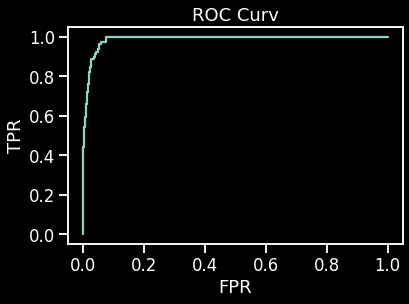

In [12]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curv')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()

## Inference

In [13]:
class BERTinferenceDataSet(Dataset):
    
    def __init__(self, sentences):
        self.sentences = sentences

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        bert_sent = tokenizer.encode_plus(sentence, 
                                         add_special_tokens = True, #[SEP][PAD]
                                         max_length = max_len,
                                         pad_to_max_length = True,
                                         truncation = True)

        ids = torch.tensor(bert_sent['input_ids'], dtype = torch.long)
        mask = torch.tensor(bert_sent['attention_mask'], dtype = torch.long)

        return{
            'ids' : ids,
            'mask' : mask
             }

In [1]:
tweets_data = pd.read_csv('PATH TO THE CSV FILE FOR ANALYSIS')
tweets_data.head()

NameError: name 'pd' is not defined

In [15]:
tweets_data['clean_text'] = tweets_data['comment_text'].apply(str).apply(lambda x: clean_text(x))

tweets_data.head()

,Unnamed: 0,Handle,comment_text,clean_text
0,0,@downatheel,Susan P downatheel 3sReplying to keaneli\nPick...,Susan P downatheel to keaneliPickled Trump he...
1,1,@fathur_irwansa,control fathur irwansa 4sThis country context ...,control fathur irwansa country context trumps...
2,2,@DJW080983,Dean Woolridge DJW080983 7sReplying to DaleS44...,Dean Woolridge to katiehobbs and GovernorHo...
3,3,@AngelCooper68,Angel Cooper AngelCooper68 7sReplying to Dylan...,Angel Cooper to DylanROrtiz iheartmindy and ...
4,4,@Huberthuertas,Hubert HUERTAS Huberthuertas 8sReplying to Bra...,Hubert HUERTAS Huberthuertas to BranaaJeanQue...


In [16]:
# reducing data set to have a faster computing speed 
# tweets_data = tweets_data.iloc[:-ENTER A NUMBER]
# len(tweets_data)

501

In [17]:
test_batch = 32
test_dataset = BERTinferenceDataSet(tweets_data['clean_text'])
test_dataloader = DataLoader(test_dataset, batch_size = test_batch, shuffle = False, num_workers = 4, pin_memory = True)
pthes = [os.path.join("../Toxic-Comment-Classification/ml-models",s) for s in os.listdir('../Toxic-Comment-Classification/ml-models') if ".pth" in s]
pthes

model = transformers.BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels = 6)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [18]:
allpreds = predicting(test_dataloader, model, pthes)

In [19]:
print('allpreds is an array with the shape of:',len(allpreds), 'x',len(allpreds[0]), 'x',len(allpreds[0][0]))
allpreds[0][0]

allpreds is an array with the shape of: 5 x 501 x 6


array([0.06182574, 0.02035525, 0.03020448, 0.01947151, 0.036041  ,
       0.02306952], dtype=float32)

In [20]:
preds = np.zeros((len(test_dataset),6))
for i in range(kfold):
    preds += allpreds[i]
preds = preds / kfold

In [21]:
results = pd.DataFrame(preds)
submission = pd.concat([test,results], axis = 1).drop(['comment_text', 'clean_text'], axis = 1)
submission.rename(columns = { 0:'toxic', 1:'severe_toxic', 2:'obscene', 3:'threat', 4:'insult', 5:'identity_hate'}, inplace = True)
submission.to_csv("SAVE FILE FOR THE ANALYSIS DATA", index = False)